## Notebook to Fit Triple Models with RV data of multiple components

In [1]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
import matplotlib.cm as cm
from read_data import read_data,read_data2,read_rv,read_wds,read_orb6
from astrometry_model import astrometry_model,astrometry_model_vlti,triple_model,triple_model_combined,triple_model_vlti_combined,triple_model_combined2,triple_model_combined3,quad_model,quad_model_combined,triple_model_vlti
from orbit_plotting import orbit_model,triple_orbit_model,quad_orbit_model
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import random
from PyAstronomy.pyasl import foldAt
from PyAstronomy import pyasl
from uncertainties import ufloat,umath
from uncertainties.umath import *
import emcee
import corner
ks=pyasl.MarkleyKESolver()

%matplotlib inline

In [2]:
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    if np.isnan(theta):
        theta_new=theta
    return(r,theta_new)

In [3]:
###########################################
## SETUP PATHS
###########################################

if os.getcwd()[7:14] == 'tgardne':
    ## setup paths for user
    path = '/Users/tgardne/ARMADA_orbits'
    path_etalon = '/Users/tgardne/etalon_epochs/etalon_fits/etalon_factors_fit.txt'
    path_wds = '/Users/tgardne/wds_targets'
    path_orb6 = '/Users/tgardne/catalogs/orb6orbits.sql.txt'
    
elif os.getcwd()[7:19] == 'adam.scovera':
    ## Adam's path
    path = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/ARMADA_orbits'
    path_etalon = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/etalon_factors_fit.txt'
    path_wds = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/wds_targets'
    path_orb6 = '/Users/adam.scovera/Documents/UofM/BEPResearch_Data/orb6orbits.sql.txt'

## Read in Data:

In [4]:
###########################################
## Specify Target
###########################################
target_hd = '173093'
note = 'rv3'

#emethod = input('bootstrap errors? (y/n) ')
emethod = 'n'

query = Simbad.query_objectids('HD %s'%target_hd)
for item in query:
    if 'HIP' in item[0]:
        target = item[0].split()[1]
        print('HIP %s'%target)
    if 'WDS' in item[0]:
        target_wds = item[0][5:15]
        print('WDS %s'%target_wds)

try:
    print(target_wds)
except:
    print('No WDS number queried')
    target_wds = input('Enter WDS: ')

HIP 91880
WDS 18439-0649
18439-0649


In [5]:
###########################################
## Read in ARMADA data
###########################################
if emethod == 'y':
    print('reading bootstrap errors')
    file=open('%s/HD_%s_bootstrap.txt'%(path,target_hd))
else:
    print('reading chi2 errors')
    file=open('%s/HD_%s_chi2err_full.txt'%(path,target_hd))
weight=1

t,p,theta,error_maj,error_min,error_pa,error_deg,p2,theta2,error_maj2,error_min2,error_pa2,error_deg2 = read_data2(file,weight)
#t,p,theta,error_maj,error_min,error_pa,error_deg = read_data(file,weight)
file.close()

## Read in RV data
file_rv=open('%s/HD_%s_rv.txt'%(path,target_hd))
#weight_rv = float(input('Err for RV [1 km/s]: '))
t_rv,rv,err_rv = read_rv(file_rv,2)
file_rv.close()

#file_rv=open('%s/HD_%s_rv_ab.txt'%(path,target_hd))
##weight_rv = float(input('Err for RV [1 km/s]: '))
#t_rv_ab,rv_ab,err_rv_ab = read_rv(file_rv,2)
#file_rv.close()

#file_rv=open('%s/HD_%s_rv_b.txt'%(path,target_hd))
##weight_rv = float(input('Err for RV [1 km/s]: '))
#t_rv_b,rv_b,err_rv_b = read_rv(file_rv,2)
#file_rv.close()

reading chi2 errors


FileNotFoundError: [Errno 2] No such file or directory: '/Users/tgardne/ARMADA_orbits/HD_173093_chi2err_full.txt'

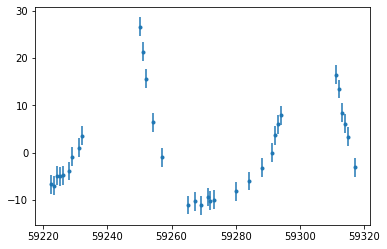

In [36]:
plt.errorbar(t_rv,rv,yerr=err_rv,fmt='.')
#plt.errorbar(t_rv_ab,rv_ab,yerr=err_rv_ab,fmt='.')
#plt.errorbar(t_rv_b,rv_b,yerr=err_rv_b,fmt='.')

plt.show()

In [37]:
### correct PAs based on precession (only for WDS):
coord = SkyCoord.from_name("HD %s"%target_hd,parse=True)
ra = coord.ra.value*np.pi/180
dec = coord.dec.value*np.pi/180
#theta -= (0.00557*np.sin(ra)/np.cos(dec)*((t-51544.5)/365.25))/180*np.pi

In [38]:
###########################################
## Apply etalon correction
###########################################
file=open(path_etalon)
mjd_etalon=[]
f_etalon=[]
for line in file.readlines():
    if line.startswith('#'):
        continue
    mjd_etalon.append(float(line.split()[0]))
    f_etalon.append(float(line.split()[1]))
file.close()
mjd_etalon=np.array(mjd_etalon)
f_etalon=np.array(f_etalon)

etalon_factor=[]
for i in t:
    idx = np.where(abs(i-mjd_etalon)==min(abs(i-mjd_etalon)))
    if min(abs(i-mjd_etalon))>0.5:
        print('Closest factor for %s is %s days away'%(i,min(abs(i-mjd_etalon))))
    f = f_etalon[idx][0]
    etalon_factor.append(f)
etalon_factor=np.array(etalon_factor)

print('   date      etalon factor')
for i,j in zip(t,etalon_factor):
    print(i,j)

## apply etalon correction
etalon = input('Apply etalon correction? (y/n) ')

## FIXME: make it easier to choose vlti data
vlti = input('Add indices for vlti (y/n)? ')
#vlti = 'y'
if vlti=='y':
    vlti_idx = input('enter indices (e.g. 1 2 3): ').split(' ')
    vlti_idx = np.array([int(i) for i in vlti_idx])
    
    vlti_mask = np.ones(len(t),dtype=bool)
    vlti_mask[vlti_idx] = False
else:
    vlti_idx = np.array([])

if etalon=='y':
    print('Applying etalon correction')
    if len(vlti_idx)>0:
        print('Setting VLTI correction factors to 1.0')
        etalon_factor[vlti_idx] = 1.0
    p = p/etalon_factor
    p2 = p2/etalon_factor
else:
    print('No etalon correction applied')
xpos=p*np.sin(theta)
ypos=p*np.cos(theta)
xpos2=p2*np.sin(theta2)
ypos2=p2*np.cos(theta2)

   date      etalon factor
58770.3846 1.0008500320628442
59076.531 1.0001222049414369
59155.3288 1.000119899159748


Apply etalon correction? (y/n)  y
Add indices for vlti (y/n)?  n


Applying etalon correction


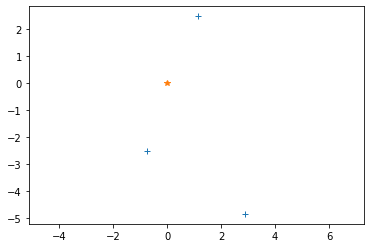

In [39]:
xpos2 = - (xpos2 - xpos)
ypos2 = ypos2 - ypos

plt.plot(xpos2,ypos2,'+')
plt.plot(0,0,'*')
plt.gca().axis('equal')
plt.show()

## Run below cell for WDS file read-in

dtype for wds (e.g. S, leave blank for ALL data):  S


Number of WDS data points = 10


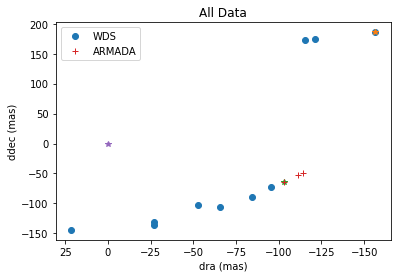

Flip WDS data? (y/n):  n


In [40]:
###########################################
## Read in WDS data - and plot to check
###########################################
input_wds = 'y'
if input_wds == 'y':
    try:
        file=open(os.path.expanduser("%s/wds%s.txt"%(path_wds,target_wds)))
        weight = 10
        dtype = input('dtype for wds (e.g. S, leave blank for ALL data): ')

        t_wds,p_wds,theta_wds,error_maj_wds,error_min_wds,error_pa_wds,error_deg_wds = read_wds(file,weight,dtype)
        print('Number of WDS data points = %s'%len(p_wds))

        ## correct WDS for PA
        theta_wds -= (0.00557*np.sin(ra)/np.cos(dec)*((t_wds-51544.5)/365.25))/180*np.pi

        xpos_wds=p_wds*np.sin(theta_wds)
        ypos_wds=p_wds*np.cos(theta_wds)

        plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
        plt.plot(xpos_wds[0],ypos_wds[0],'*')
        try:
            idx = np.argmin(t)
            plt.plot(xpos[idx],ypos[idx],'*')
            plt.plot(xpos,ypos,'+',label='ARMADA')
        except:
            pass
        plt.plot(0,0,'*')
        plt.gca().invert_xaxis()
        plt.title('All Data')
        plt.xlabel('dra (mas)')
        plt.ylabel('ddec (mas)')
        plt.legend()
        plt.show()

        flip = input('Flip WDS data? (y/n): ')
        if flip=='y':
            xpos_wds=-p_wds*np.sin(theta_wds)
            ypos_wds=-p_wds*np.cos(theta_wds)
            plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
            plt.plot(xpos_wds[0],ypos_wds[0],'*')
            try:
                plt.plot(xpos[idx],ypos[idx],'*')
                plt.plot(xpos,ypos,'+',label='ARMADA')
            except:
                pass
            plt.plot(0,0,'*')
            plt.gca().invert_xaxis()
            plt.title('All Data')
            plt.xlabel('dra (mas)')
            plt.ylabel('ddec (mas)')
            plt.legend()
            plt.show()

            better = input('Flip data back to original? (y/n): ')
            if better=='y':
                xpos_wds=p_wds*np.sin(theta_wds)
                ypos_wds=p_wds*np.cos(theta_wds)
    except:
        t_wds = np.array([np.nan])
        p_wds = np.array([np.nan])
        theta_wds = np.array([np.nan])
        error_maj_wds = np.array([np.nan])
        error_min_wds = np.array([np.nan])
        error_pa_wds = np.array([np.nan])
        error_deg_wds = np.array([np.nan])
        xpos_wds=p_wds*np.sin(theta_wds)
        ypos_wds=p_wds*np.cos(theta_wds)
        print('NO WDS NUMBER')
else:
    t_wds = np.array([np.nan])
    p_wds = np.array([np.nan])
    theta_wds = np.array([np.nan])
    error_maj_wds = np.array([np.nan])
    error_min_wds = np.array([np.nan])
    error_pa_wds = np.array([np.nan])
    error_deg_wds = np.array([np.nan])
    xpos_wds=p_wds*np.sin(theta_wds)
    ypos_wds=p_wds*np.cos(theta_wds)
    print('NO WDS DATA')

## Run below cell for WDS from a previous fit

In [ ]:
file_wds = open('/Users/tgardne/ARMADA_orbits/HD1976_chi2err/HD_1976_wds.txt')
p_wds=[]
degrees_wds=[]  #text file is in degrees
t_wds=[]
t_date_wds=[]
error_maj_wds=[]
error_min_wds=[]
error_pa_wds=[]
for line in file_wds.readlines():
    if line.startswith('#'):
        continue
    p_wds.append(float(line.split()[2]))
    degrees_wds.append(float(line.split()[3]))
    t_wds.append(float(line.split()[1]))
    t_date_wds.append(line.split()[0])
    if line.split()[4]=='--':
        error_maj_wds.append(0.1)
        error_min_wds.append(0.1)
        error_pa_wds.append(0)
    else:
        error_maj_wds.append(float(line.split()[4]))
        error_min_wds.append(float(line.split()[5]))
        epa = float(line.split()[6])
        #if epa>0:
        #    epa=90-epa
        #else:
        #    epa=abs(epa)+90
        error_pa_wds.append(epa)
file_wds.close()
degrees_wds=np.array(degrees_wds)
p_wds=np.array(p_wds)
t_wds=np.array(t_wds)
theta_wds=np.array(degrees_wds)*(np.pi/180)

error_maj_wds=weight*np.asarray(error_maj_wds)
error_min_wds=weight*np.asarray(error_min_wds)

error_deg_wds=np.asarray(error_pa_wds)
error_pa_wds=error_deg_wds*np.pi/180.

####################
## Plot to check:
####################
xpos_wds=p_wds*np.sin(theta_wds)
ypos_wds=p_wds*np.cos(theta_wds)
plt.plot(xpos_wds,ypos_wds,'o',label='WDS')
plt.plot(xpos_wds[0],ypos_wds[0],'*')
try:
    idx = np.argmin(t)
    plt.plot(xpos[idx],ypos[idx],'*')
    plt.plot(xpos,ypos,'+',label='ARMADA')
except:
    pass
plt.plot(0,0,'*')
plt.gca().invert_xaxis()
plt.title('All Data')
plt.xlabel('dra (mas)')
plt.ylabel('ddec (mas)')
plt.legend()
plt.show()

In [41]:
###########################################
## Get an estimate of the orbital parameters
###########################################
try:
    a,P,e,inc,omega,bigomega,T = read_orb6(target,path_orb6)
except:
    print('No elements found in ORB6. Will need to enter your own.')

self_params = 'n'
if self_params=='y':
    a = float(input('a (mas): '))
    P = float(input('P (year): '))*365.25
    e = float(input('ecc : '))
    inc = float(input('inc (deg): '))
    omega = float(input('omega (deg): '))
    bigomega = float(input('bigomega (deg): '))
    T = float(input('T (mjd): '))

found target!
--------------------------
a(mas),P(yr),e,i(deg),omega(deg),bigomega(deg),T(mjd)
333.0 48.47999999999999 0.828 78.4 281.2 152.5 52884.46887400013
--------------------------


In [42]:
###########################################
## Combined WDS+ARMADA for fitting
###########################################
xpos_all = np.concatenate([xpos,xpos_wds])
ypos_all = np.concatenate([ypos,ypos_wds])
t_all = np.concatenate([t,t_wds])
error_maj_all = np.concatenate([error_maj,error_maj_wds])
error_min_all = np.concatenate([error_min,error_min_wds])
error_pa_all = np.concatenate([error_pa,error_pa_wds])
error_deg_all = np.concatenate([error_deg,error_deg_wds])

if vlti=='y':
    vlti_mask_all = np.ones(len(t_all),dtype=bool)
    vlti_mask_all[vlti_idx] = False

## Fit Outer Binary

In [43]:
##########################################
## Function for fitting/plotting data
#########################################
def ls_fit(params,xp,yp,tp,emaj,emin,epa):
    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(astrometry_model_vlti, params, fcn_args=(xp[vlti_mask_all],yp[vlti_mask_all],tp[vlti_mask_all],
                                                        emaj[vlti_mask_all],emin[vlti_mask_all],epa[vlti_mask_all],
                                                        xp[vlti_idx],yp[vlti_idx],tp[vlti_idx],
                                                        emaj[vlti_idx],emin[vlti_idx],epa[vlti_idx]),
                                nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(astrometry_model, params, fcn_args=(xp,yp,tp,
                                                        emaj,emin,epa),
                                nan_policy='omit')
        result = minner.minimize()

    # write error report
    print(report_fit(result))

    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                 error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
    print('-'*10)
    print('chi2 armada = %s'%chi2_armada)
    print('-'*10)

    ## plot fit
    scale=1
    if chi2_armada<1.0 and chi2_armada>0:
        scale=1/np.sqrt(chi2_armada)
    a_start = result.params['a']
    P_start = result.params['P']
    e_start = result.params['e']
    inc_start = result.params['inc']
    w_start = result.params['w']
    bigw_start = result.params['bigw']
    T_start = result.params['T']
    mirc_scale_start = result.params['mirc_scale']

    ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                            w_start,bigw_start,P_start,
                                            T_start,t_all)
    fig,ax=plt.subplots()
    ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
    if len(vlti_idx)>0:
        ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
        ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
    else:
        ax.plot(xpos,ypos,'o', label='ARMADA')
    ax.plot(0,0,'*')
    ax.plot(ra, dec, '--',color='g')
    #plot lines from data to best fit orbit
    i=0
    while i<len(decpoints):
        x=[xpos_all[i],rapoints[i]]
        y=[ypos_all[i],decpoints[i]]
        ax.plot(x,y,color="black")
        i+=1
    ax.set_xlabel('milli-arcsec')
    ax.set_ylabel('milli-arcsec')
    ax.invert_xaxis()
    ax.axis('equal')
    ax.set_title('HD%s Outer Orbit'%target_hd)
    plt.legend()
    plt.show()

    return result

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 133
    # data points      = 26
    # variables        = 7
    chi-square         = 72.3364900
    reduced chi-square = 3.80718369
    Akaike info crit   = 40.6040363
    Bayesian info crit = 49.4107121
[[Variables]]
    w:           283.018152 +/- 3.01470107 (1.07%) (init = 281.2)
    bigw:        152.089759 +/- 2.37958667 (1.56%) (init = 152.5)
    inc:         73.3508187 +/- 2.11848711 (2.89%) (init = 78.4)
    e:           0.69495750 +/- 0.04202999 (6.05%) (init = 0.828)
    a:           266.960379 +/- 25.5528275 (9.57%) (init = 333)
    P:           15808.0544 +/- 1000.24446 (6.33%) (init = 17695.2)
    T:           53240.0516 +/- 295.303515 (0.55%) (init = 52884.47)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(inc, a)    =  0.974
    C(inc, e)    =  0.921
    C(e, a)      =  0.854
    C(inc, T)    = -0.720
    C(a, T)      = -0.695
    C(w, e)      = -0.674
    

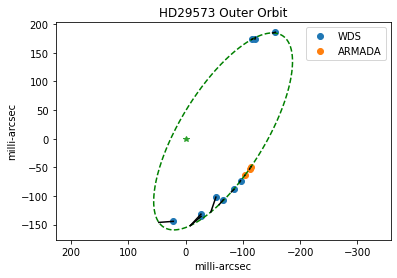

In [44]:
params = Parameters()
params.add('w',   value= omega, min=0, max=360)
params.add('bigw', value= bigomega, min=0, max=360)
params.add('inc', value= inc, min=0, max=180)
params.add('e', value= e, min=0, max=0.99)
params.add('a', value= a, min=0)
params.add('P', value= P, min=0)
params.add('T', value= T, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

result = ls_fit(params,xpos_all,ypos_all,t_all,error_maj_all,error_min_all,error_pa_all)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 648
    # data points      = 6
    # variables        = 6
    chi-square         = 2.63905057
    reduced chi-square = 2.63905057
    Akaike info crit   = 7.07195851
    Bayesian info crit = 5.82251533
[[Variables]]
    w:           359.999999 +/- 51.5532671 (14.32%) (init = 198.5)
    bigw:        342.273828 +/- 14.2741536 (4.17%) (init = 330.4)
    inc:         110.051370 +/- 5.91607822 (5.38%) (init = 83.7)
    e:           0.43 (fixed)
    a:           5.30256084 +/- 0.82943806 (15.64%) (init = 5)
    P:           53.1183155 +/- 0.46993717 (0.88%) (init = 59.2)
    T:           57286.5713 +/- 11.8523732 (0.02%) (init = 57056.1)
    mirc_scale:  1 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(P, T)      = -0.934
    C(w, bigw)   =  0.844
    C(w, P)      =  0.765
    C(w, a)      =  0.690
    C(bigw, P)   =  0.613
    C(a, P)      =  0.597
    C(bigw, a)   =  0.535
    C(w, T)      = 

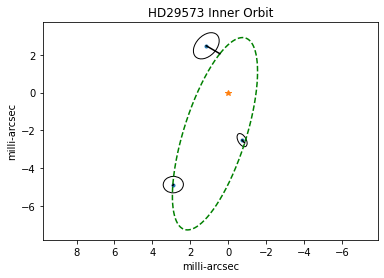

In [46]:
## Fit inner orbit
params = Parameters()
params.add('w',   value= 198.5, min=0, max=360)
params.add('bigw', value= 330.4, min=0, max=360)
params.add('inc', value= 83.7, min=0, max=180)
params.add('e', value= 0.43, vary=False)#min=0, max=0.99)
params.add('a', value= 5, min=0)
params.add('P', value= 59.2, min=0)
params.add('T', value= 57056.1, min=0)
if len(vlti_idx)>0:
    params.add('mirc_scale', value=1)
else:
    params.add('mirc_scale',value=1,vary=False)

minner = Minimizer(astrometry_model, params, fcn_args=(xpos2,ypos2,t,
                        error_maj2,error_min2,error_pa2),nan_policy='omit')
result = minner.minimize()

# write error report
print(report_fit(result))

## plot fit
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']

ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t)
fig,ax=plt.subplots()
ax.plot(xpos2, ypos2, '.')
ax.plot(0,0,'*')

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle in zip(xpos2,ypos2,error_maj2,error_min2,error_deg2):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos2[i],rapoints[i]]
    y=[ypos2[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
plt.show()

----------
chi2 armada = 7.255851223498113
----------


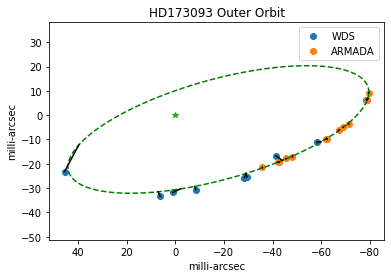

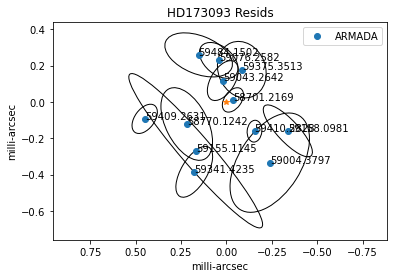

----------
Mean residual = 275.33 micro-as
----------


In [14]:
##########################################
## Save Plots
##########################################
if len(vlti_idx)>0:
    resids_armada = astrometry_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = astrometry_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))
chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-7)
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

directory='%s/HD%s_chi2err_triple/'%(path,target_hd)
if not os.path.exists(directory):
    os.makedirs(directory)

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
a_start = result.params['a']
P_start = result.params['P']
e_start = result.params['e']
inc_start = result.params['inc']
w_start = result.params['w']
bigw_start = result.params['bigw']
T_start = result.params['T']
mirc_scale_start = result.params['mirc_scale']
ra,dec,rapoints,decpoints = orbit_model(a_start,e_start,inc_start,
                                        w_start,bigw_start,P_start,
                                        T_start,t_all)
fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx]*mirc_scale_start,ypos[vlti_idx]*mirc_scale_start,'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## plot resids for ARMADA
fig,ax=plt.subplots()
if len(vlti_idx)>0:
    xresid_vlti = xpos[vlti_idx]*mirc_scale_start - rapoints[:len(xpos)][vlti_idx]
    yresid_vlti = ypos[vlti_idx]*mirc_scale_start - decpoints[:len(ypos)][vlti_idx]
    xresid_chara = xpos[vlti_mask] - rapoints[:len(xpos)][vlti_mask]
    yresid_chara = ypos[vlti_mask] - decpoints[:len(ypos)][vlti_mask]
    xresid = np.concatenate([xresid_chara,xresid_vlti])
    yresid = np.concatenate([yresid_chara,yresid_vlti])
else:
    xresid = xpos - rapoints[:len(xpos)]
    yresid = ypos - decpoints[:len(ypos)]

#need to measure error ellipse angle east of north
for ras, decs, w, h, angle, d in zip(xresid,yresid,error_maj/scale,error_min/scale,error_deg,t):
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                      angle=90-angle, facecolor='none', edgecolor='black')
    ax.annotate(d,xy=(ras,decs))
    ax.add_patch(ellipse)

if len(vlti_idx)>0:
    ax.plot(xresid[vlti_idx],yresid[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xresid[vlti_mask],yresid[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xresid,yresid,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Resids'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_resid_binary.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

## residuals
resids = np.sqrt(xresid**2 + yresid**2)
resids_median = np.around(np.median(resids)*1000,2)
print('-'*10)
print('Mean residual = %s micro-as'%resids_median)
print('-'*10)

## Save txt file with best orbit
f = open("%s/%s_%s_orbit_binary.txt"%(directory,target_hd,note),"w+")
f.write("# P(d) a(mas) e i(deg) w(deg) W(deg) T(mjd) mirc_scale mean_resid(mu-as)\r\n")
f.write("%s %s %s %s %s %s %s %s %s"%(P_start.value,a_start.value,e_start.value,
                                   inc_start.value*180/np.pi,w_start.value*180/np.pi,
                                   bigw_start.value*180/np.pi,T_start.value,
                                  mirc_scale_start.value,resids_median))
f.close()

## Run below cell for TRIPLE + RV Fit:

In [15]:
## Try a quad fit -- giving two orbital periods
## Do a fit at best period

P2_best = []
a2_best = []
a_inner_best = []
e2_best = []
w2_best = []
bigw2_best = []
inc2_best = []
T2_best = []

P_best = []
a_best = []
e_best = []
w_best = []
bigw_best = []
inc_best = []
T_best = []
mirc_scale_best = []
chi2_results = []

K_a_best = []
K_aa_best = []
K_ab_best = []
K_b_best = []
gamma_best = []

circular = 'y'
P2_guess = 2.358
i2_guess = 20
a2_guess = 0.3
a_inner_guess = 0.3

K_aa_guess = 20
K_ab_guess = 20
K_a_guess = 10
K_b_guess = 30
gamma_guess = -50

for i in tqdm(np.arange(20)):
    bigw2 = random.uniform(0,360)
    #bigw2 = 107
    T2 = random.uniform(min(t_rv_aa)-P2_guess,max(t_rv_aa)+P2_guess)
    #T2 = 55058.9
    if i2_guess == 'n':
        inc2 = random.uniform(0,180)
    else:
        inc2 = i2_guess
        
    if circular!='y':
        e2 = random.uniform(0,0.99)
        w2 = random.uniform(0,360)
        
    params = Parameters()
    params.add('w',   value = omega, min=0, max=360)
    params.add('bigw', value = bigomega, min=0, max=360)
    params.add('inc', value = inc, min=0, max=180)
    params.add('e', value = e, min=0, max=0.99)
    params.add('a', value = a, min=0)
    params.add('P', value = P, min=0)
    params.add('T', value = T, min=0)

    if circular!='y':
        params.add('w2',   value= w2, min=0, max=360)
        params.add('e2', value= e2, min=0,max=0.99)
    else:
        params.add('w2',   value= 0, vary=False)
        params.add('e2', value= 0, vary=False)
        
    params.add('bigw2', value= bigw2, min=0, max=360)
    params.add('inc2', value= inc2, min=0, max=180)
    params.add('a2', value= a2_guess, min=0)
    params.add('a_inner', value= a_inner_guess, min=0)
    params.add('P2', value= P2_guess, min=0)
    params.add('T2', value= T2, min=0)

    params.add('K_aa', value= K_aa_guess,min=0)
    params.add('K_ab', value= K_ab_guess,min=0)
    params.add('K_a', value= K_a_guess,min=0)
    params.add('K_b', value= K_b_guess,min=0)
    params.add('gamma', value= gamma_guess)

    if len(vlti_idx)>0:
        params.add('mirc_scale', value=1)
    else:
        params.add('mirc_scale',value=1,vary=False)

    #params.add('pscale', value=1)

    #do fit, minimizer uses LM for least square fitting of model to data
    if len(vlti_idx)>0:
        minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                            error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                            error_pa_all[vlti_mask_all],
                                                            xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                            error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                            error_pa_all[vlti_idx],rv,t_rv,err_rv),
                            nan_policy='omit')
        result = minner.minimize()
    else:
        minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                            error_maj_all,error_min_all,
                                                            error_pa_all, xpos2,ypos2,t,
                                                            error_maj2,error_min2,
                                                            error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                            rv_ab,t_rv_ab,err_rv_ab,
                                                            rv_b,t_rv_b,err_rv_b),
                            nan_policy='omit')
        result = minner.minimize()

    P2_best.append(result.params['P2'])
    a2_best.append(result.params['a2'])
    a_inner_best.append(result.params['a_inner'])
    e2_best.append(result.params['e2'])
    w2_best.append(result.params['w2'])
    bigw2_best.append(result.params['bigw2'])
    inc2_best.append(result.params['inc2'])
    T2_best.append(result.params['T2'])

    P_best.append(result.params['P'])
    a_best.append(result.params['a'])
    e_best.append(result.params['e'])
    w_best.append(result.params['w'])
    bigw_best.append(result.params['bigw'])
    inc_best.append(result.params['inc'])
    T_best.append(result.params['T'])

    mirc_scale_best.append(result.params['mirc_scale'])
    chi2_results.append(result.redchi)
    
    K_aa_best.append(result.params['K_aa'])
    K_ab_best.append(result.params['K_ab'])
    K_a_best.append(result.params['K_a'])
    K_b_best.append(result.params['K_b'])
    gamma_best.append(result.params['gamma'])

100%|██████████| 20/20 [03:02<00:00,  9.11s/it]


In [16]:
P2_best = np.array(P2_best)
a2_best = np.array(a2_best)
a_inner_best = np.array(a_inner_best)
e2_best = np.array(e2_best)
w2_best = np.array(w2_best)
bigw2_best = np.array(bigw2_best)
inc2_best = np.array(inc2_best)
T2_best = np.array(T2_best)

P_best = np.array(P_best)
a_best = np.array(a_best)
e_best = np.array(e_best)
w_best = np.array(w_best)
bigw_best = np.array(bigw_best)
inc_best = np.array(inc_best)
T_best = np.array(T_best)
mirc_scale_best = np.array(mirc_scale_best)
chi2_results = np.array(chi2_results)

K_aa_best = np.array(K_aa_best)
K_ab_best = np.array(K_ab_best)
K_a_best = np.array(K_a_best)
K_b_best = np.array(K_b_best)
gamma_best = np.array(gamma_best)

idx = np.argmin(chi2_results)
P2_best = P2_best[idx]
a2_best = a2_best[idx]
a_inner_best = a_inner_best[idx]
e2_best = e2_best[idx]
w2_best = w2_best[idx]
bigw2_best = bigw2_best[idx]
inc2_best = inc2_best[idx]
T2_best = T2_best[idx]

P_best = P_best[idx]
a_best = a_best[idx]
e_best = e_best[idx]
w_best = w_best[idx]
bigw_best = bigw_best[idx]
inc_best = inc_best[idx]
T_best = T_best[idx]
mirc_scale_best = mirc_scale_best[idx]

K_aa_best = K_aa_best[idx]
K_ab_best = K_ab_best[idx]
K_a_best = K_a_best[idx]
K_b_best = K_b_best[idx]
gamma_best = gamma_best[idx]

In [17]:
## Save a fit for errors
circular = 'y'

params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('a_inner', value= a_inner_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

params.add('K_aa', value= K_aa_best)
params.add('K_ab', value= K_ab_best)
params.add('K_a', value= K_a_best)
params.add('K_b', value= K_b_best)
#params.add('K', value= 22)
#params.add('K_outer', value= 10)
params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if len(vlti_idx)>0:
    minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                        error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                        error_pa_all[vlti_mask_all],
                                                        xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                        error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                        error_pa_all[vlti_idx],rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,xpos2,ypos2,t,
                                                        error_maj2,error_min2,
                                                        error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                rv_ab,t_rv_ab,err_rv_ab,
                                                                rv_b,t_rv_b,err_rv_b),
                        nan_policy='omit')
    result = minner.minimize()

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 1011
    # variables        = 18
    chi-square         = 268.934656
    reduced chi-square = 0.27083047
    Akaike info crit   = -1302.79328
    Bayesian info crit = -1214.25676
[[Variables]]
    w:           255.705004 +/- 0.11619605 (0.05%) (init = 255.705)
    bigw:        287.699873 +/- 0.05453401 (0.02%) (init = 287.6999)
    inc:         104.194355 +/- 0.03819413 (0.04%) (init = 104.1944)
    e:           0.60610731 +/- 0.00108175 (0.18%) (init = 0.6061074)
    a:           82.1720648 +/- 0.14744431 (0.18%) (init = 82.17206)
    P:           2639.40114 +/- 1.32564843 (0.05%) (init = 2639.401)
    T:           55471.8941 +/- 0.55531559 (0.00%) (init = 55471.89)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       116.735201 +/- 1.32018570 (1.13%) (init = 116.7349)
    inc2:        14.5610108 +/- 9.08604753 (62.40%) (init = 14.56273)
    a2:          0.3095528

In [22]:
## scale errors based on chi2
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    resids_chara = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],[],[],[],[],[],[])
    resids_vlti = triple_model_vlti(result.params,[],[],[],[],[],[],xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],error_maj[vlti_idx],
                                error_min[vlti_idx],error_pa[vlti_idx])
    
    ndata_armada = 2*sum(~np.isnan(xpos))
    ndata_chara = 2*sum(~np.isnan(xpos[vlti_mask]))
    ndata_vlti = 2*sum(~np.isnan(xpos[vlti_idx]))
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
    ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-17)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-17)
    except:
        pass
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    try:
        chi2_chara = np.nansum(resids_chara**2)/(ndata_chara-19)
        chi2_vlti = np.nansum(resids_vlti**2)/(ndata_vlti-19)
    except:
        pass
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

try:
    print('-'*10)
    print('chi2 chara = %s'%chi2_chara)
    print('-'*10)
    
    print('-'*10)
    print('chi2 vlti = %s'%chi2_vlti)
    print('-'*10)
except:
    pass

24
21
----------
chi2 armada = 1.3896629318032645
----------
----------


In [19]:
1/np.sqrt(0.29)

1.8569533817705188

In [20]:
## scale errors
armada_scale = 2
vlti_scale = 1
chara_scale = 1

if len(vlti_idx)>0:
    error_maj[vlti_idx]/=vlti_scale
    error_min[vlti_idx]/=vlti_scale
    error_maj_all[vlti_idx]/=vlti_scale
    error_min_all[vlti_idx]/=vlti_scale
    
    error_maj[vlti_mask]/=chara_scale
    error_min[vlti_mask]/=chara_scale
    error_maj_all[vlti_mask_all]/=chara_scale
    error_min_all[vlti_mask_all]/=chara_scale
    
else:
    error_maj/=armada_scale
    error_min/=armada_scale
    error_maj2/=armada_scale
    error_min2/=armada_scale
    error_maj_all[:len(error_maj)]/=armada_scale
    error_min_all[:len(error_maj)]/=armada_scale

In [21]:
## Save a fit for errors
params = Parameters()
params.add('w',   value = w_best, min=0, max=360)
params.add('bigw', value = bigw_best, min=0, max=360)
params.add('inc', value = inc_best, min=0, max=180)
params.add('e', value = e_best, min=0, max=0.99)
params.add('a', value = a_best, min=0)
params.add('P', value = P_best, min=0)
params.add('T', value = T_best, min=0)

if circular!='y':
    params.add('w2',   value= w2_best, min=0, max=360)
    params.add('e2', value= e2_best, min=0,max=0.99)
else:
    params.add('w2',   value= 0, vary=False)
    params.add('e2', value= 0, vary=False)
        
params.add('bigw2', value= bigw2_best, min=0, max=360)
params.add('inc2', value= inc2_best, min=0, max=180)
params.add('a2', value= a2_best, min=0)
params.add('a_inner', value= a_inner_best, min=0)
params.add('P2', value= P2_best, min=0)
params.add('T2', value= T2_best, min=0)

params.add('K_aa', value= K_aa_best, min=0)
params.add('K_ab', value= K_ab_best, min=0)
params.add('K_a', value= K_a_best, min=0)
params.add('K_b', value= K_b_best, min=0)
params.add('gamma', value= gamma_best)

if len(vlti_idx)>0:
    params.add('mirc_scale', value=mirc_scale_best)
else:
    params.add('mirc_scale',value=1,vary=False)

#params.add('pscale', value=1)

#do fit, minimizer uses LM for least square fitting of model to data
if len(vlti_idx)>0:
    minner = Minimizer(triple_model_vlti_combined, params, fcn_args=(xpos_all[vlti_mask_all],ypos_all[vlti_mask_all],t_all[vlti_mask_all],
                                                        error_maj_all[vlti_mask_all],error_min_all[vlti_mask_all],
                                                        error_pa_all[vlti_mask_all],
                                                        xpos_all[vlti_idx],ypos_all[vlti_idx],t_all[vlti_idx],
                                                        error_maj_all[vlti_idx],error_min_all[vlti_idx],
                                                        error_pa_all[vlti_idx],rv,t_rv,err_rv),
                        nan_policy='omit')
    result = minner.minimize()
else:
    minner = Minimizer(triple_model_combined3, params, fcn_args=(xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,xpos2,ypos2,t,
                                                        error_maj2,error_min2,
                                                        error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                rv_ab,t_rv_ab,err_rv_ab,
                                                                rv_b,t_rv_b,err_rv_b),
                        nan_policy='omit')
    result = minner.minimize()

report_fit(result)

P2_best = result.params['P2'].value
a2_best = result.params['a2'].value
a_inner_best = result.params['a_inner'].value
e2_best = result.params['e2'].value
w2_best = result.params['w2'].value
bigw2_best = result.params['bigw2'].value
inc2_best = result.params['inc2'].value
T2_best = result.params['T2'].value

P_best = result.params['P'].value
a_best = result.params['a'].value
e_best = result.params['e'].value
w_best = result.params['w'].value
bigw_best = result.params['bigw'].value
inc_best = result.params['inc'].value
T_best = result.params['T'].value
mirc_scale_best = result.params['mirc_scale'].value

K_aa_best = result.params['K_aa'].value
K_ab_best = result.params['K_ab'].value
K_a_best = result.params['K_a'].value
K_b_best = result.params['K_b'].value
gamma_best = result.params['gamma'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 1011
    # variables        = 18
    chi-square         = 279.583478
    reduced chi-square = 0.28155436
    Akaike info crit   = -1263.53364
    Bayesian info crit = -1174.99713
[[Variables]]
    w:           255.761752 +/- 0.11588118 (0.05%) (init = 255.705)
    bigw:        287.603509 +/- 0.03648848 (0.01%) (init = 287.6999)
    inc:         104.194662 +/- 0.03633772 (0.03%) (init = 104.1944)
    e:           0.60408613 +/- 9.2507e-04 (0.15%) (init = 0.6061074)
    a:           82.1439226 +/- 0.14547820 (0.18%) (init = 82.17206)
    P:           2640.89393 +/- 1.24845115 (0.05%) (init = 2639.401)
    T:           55471.9355 +/- 0.56767231 (0.00%) (init = 55471.89)
    w2:          0 (fixed)
    e2:          0 (fixed)
    bigw2:       116.744624 +/- 0.72640607 (0.62%) (init = 116.7349)
    inc2:        14.5665439 +/- 4.62961412 (31.78%) (init = 14.56273)
    a2:          0.3134912

24
21
----------
chi2 armada = 1.3896629318032645
----------


scale errors by:  1


/Users/tgardne/armada_binaries/orbit_plotting.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':
/Users/tgardne/armada_binaries/orbit_plotting.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':


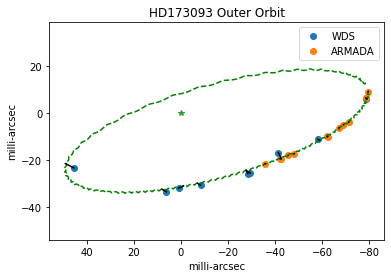

In [23]:
##########################################
## Save Plots for Triple
##########################################
if len(vlti_idx)>0:
    resids_armada = triple_model_vlti(result.params,xpos[vlti_mask],ypos[vlti_mask],t[vlti_mask],error_maj[vlti_mask],
                                error_min[vlti_mask],error_pa[vlti_mask],
                                xpos[vlti_idx],ypos[vlti_idx],t[vlti_idx],
                                error_maj[vlti_idx],error_min[vlti_idx],error_pa[vlti_idx])
else:
    resids_armada = triple_model(result.params,xpos,ypos,t,error_maj,
                                error_min,error_pa)
ndata_armada = 2*sum(~np.isnan(xpos))

if circular=='y':
    print(ndata_armada)
    print(len(result.params))
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-17)
else:
    chi2_armada = np.nansum(resids_armada**2)/(ndata_armada-19)
    
print('-'*10)
print('chi2 armada = %s'%chi2_armada)
print('-'*10)

if len(vlti_idx)>0:
    xpos[vlti_idx]*=mirc_scale_best
    ypos[vlti_idx]*=mirc_scale_best
    xpos_all[vlti_idx]*=mirc_scale_best
    ypos_all[vlti_idx]*=mirc_scale_best
else:
    idx = np.where(t<58757)
    xpos[idx]/=mirc_scale_best
    ypos[idx]/=mirc_scale_best
    idx = np.where(t_all<58757)
    xpos_all[idx]/=mirc_scale_best
    ypos_all[idx]/=mirc_scale_best

## plot fit
scale=1
if chi2_armada<1.0 and chi2_armada>0:
    scale=1/np.sqrt(chi2_armada)
else:
    scale=float(input('scale errors by: '))

tmodel = np.linspace(t_all[0],t_all[0]+P,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos_all[len(xpos):], ypos_all[len(xpos):], 'o', label='WDS')
if len(vlti_idx)>0:
    ax.plot(xpos[vlti_idx],ypos[vlti_idx],'o', label='ARMADA-VLTI')
    ax.plot(xpos[vlti_mask],ypos[vlti_mask],'o', label='ARMADA-CHARA')
else:
    ax.plot(xpos,ypos,'o', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')
#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos_all[i],rapoints[i]]
    y=[ypos_all[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Outer Orbit'%target_hd)
plt.legend()
plt.savefig('%s/HD%s_%s_outer_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

/Users/tgardne/armada_binaries/orbit_plotting.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':
/Users/tgardne/armada_binaries/orbit_plotting.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':


Scale for triple =  1


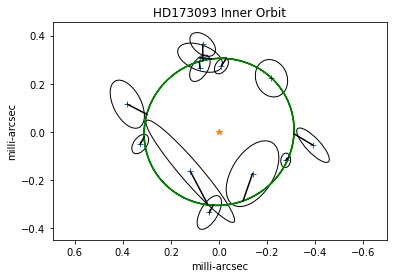

In [24]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

fig,ax=plt.subplots()
if len(vlti_idx)>0:
    ax.plot(xpos_inner[:len(xpos)][vlti_idx],ypos_inner[:len(xpos)][vlti_idx],'+', label='ARMADA-VLTI')
    ax.plot(xpos_inner[:len(xpos)][vlti_mask],ypos_inner[:len(xpos)][vlti_mask],'+', label='ARMADA-CHARA')
else:
    ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', label='ARMADA')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

/Users/tgardne/armada_binaries/orbit_plotting.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':


Scale for triple =  1


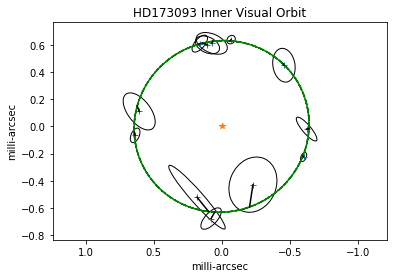

In [25]:
## plot inner orbit
#idx = np.where(error_maj/scale<1)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = orbit_model(a_inner_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t,tmodel)

fig,ax=plt.subplots()
ax.plot(xpos2,ypos2,'+')
ax.plot(0,0,'*')
ax.plot(ra, dec, '--',color='g')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos2,ypos2,error_maj2/scale,error_min2/scale,error_deg2):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints):
    x=[xpos2[i],rapoints[i]]
    y=[ypos2[i],decpoints[i]]
    ax.plot(x,y,color="black")
    i+=1
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Visual Orbit'%target_hd)
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_visual.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

/Users/tgardne/armada_binaries/orbit_plotting.py:29: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':
/Users/tgardne/armada_binaries/orbit_plotting.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmodel=='None':


1.0646614731471795


Scale for triple =  1


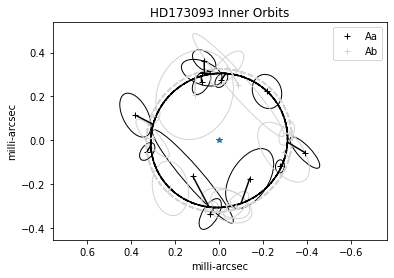

In [26]:
## plot inner wobble
#idx = np.where(error_maj/scale<1)

mratio = (a_inner_best-a2_best)/a2_best
print(mratio)

tmodel = np.linspace(t[0],t[0]+3*P2_best,1000)
ra,dec,rapoints,decpoints = triple_orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,a2_best,e2_best,
                                        inc2_best,w2_best,bigw2_best,
                                        P2_best,T2_best,
                                        t_all,tmodel)
ra2,dec2,rapoints2,decpoints2 = orbit_model(a_best,e_best,inc_best,
                                        w_best,bigw_best,P_best,
                                        T_best,t_all,tmodel)
ra3,dec3,rapoints3,decpoints3 = orbit_model(-mratio*a2_best,e2_best,inc2_best,
                                        w2_best,bigw2_best,P2_best,
                                        T2_best,t,tmodel)

ra_inner = ra - ra2
dec_inner = dec - dec2
rapoints_inner = rapoints - rapoints2
decpoints_inner = decpoints - decpoints2

xpos_inner = xpos_all - rapoints2
ypos_inner = ypos_all - decpoints2

xpos_inner2 = -xpos2 / (1+mratio)
ypos_inner2 = -ypos2 / (1+mratio)

fig,ax=plt.subplots()
ax.plot(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],'+', color='black', label='Aa')
ax.plot(xpos_inner2,ypos_inner2,'+', color='lightgrey', label='Ab')
ax.plot(0,0,'*')
ax.plot(ra_inner, dec_inner, '--',color='black')
ax.plot(ra3, dec3, '--',color='lightgrey')

#need to measure error ellipse angle east of north
scale = float(input('Scale for triple = '))
for ras, decs, w, h, angle in zip(xpos_inner[:len(xpos)],ypos_inner[:len(xpos)],error_maj/scale,error_min/scale,error_deg):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='black')
    ax.add_patch(ellipse)
    
for ras, decs, w, h, angle in zip(xpos_inner2,ypos_inner2,error_maj2/scale,error_min2/scale,error_deg2):
    #if w<0.05:
    ellipse = Ellipse(xy=(ras, decs), width=2*w, height=2*h, 
                        angle=90-angle, facecolor='none', edgecolor='lightgrey')
    ax.add_patch(ellipse)

#plot lines from data to best fit orbit
i=0
while i<len(decpoints_inner[:len(xpos)]):
    x=[xpos_inner[:len(xpos)][i],rapoints_inner[:len(xpos)][i]]
    y=[ypos_inner[:len(xpos)][i],decpoints_inner[:len(xpos)][i]]
    ax.plot(x,y,color="black")
    i+=1
i=0
while i<len(decpoints3):
    x=[xpos_inner2[i],rapoints3[i]]
    y=[ypos_inner2[i],decpoints3[i]]
    ax.plot(x,y,color="lightgrey")
    i+=1
    
ax.set_xlabel('milli-arcsec')
ax.set_ylabel('milli-arcsec')
ax.invert_xaxis()
ax.axis('equal')
ax.set_title('HD%s Inner Orbits'%target_hd)
plt.legend()
#plt.legend()
plt.savefig('%s/HD%s_%s_inner_triple_full.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [ ]:
## Plot RV results:
foldtime_aa = foldAt(t_rv_aa,P2_best,T0=T2_best)
foldtime_ab = foldAt(t_rv_ab,P2_best,T0=T2_best)
foldtime_a = foldAt(t_rv_aa,P_best,T0=T_best)
foldtime_b = foldAt(t_rv_b,P_best,T0=T_best)

tt=np.linspace(T2_best,T2_best+P2_best*0.99,100)
tt_b=np.linspace(T_best,T_best+P_best*0.99,100)

MM=[]
for i in tt:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM.append(mm_anom)
MM=np.asarray(MM)

EE=[]
for j in MM:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE.append(ee_anom)
EE=np.asarray(EE)

MM_b=[]
for i in tt_b:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM_b.append(mm_anom)
MM_b=np.asarray(MM_b)

EE_b=[]
for j in MM_b:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE_b.append(ee_anom)
EE_b=np.asarray(EE_b)

MM_inner_aa=[]
for i in t_rv_aa:
    mm_anom=2*np.pi/P2_best*(i-T2_best)
    MM_inner_aa.append(mm_anom)
MM_inner_aa=np.asarray(MM_inner_aa)
EE_inner_aa=[]
for j in MM_inner_aa:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e2_best)
    EE_inner_aa.append(ee_anom)
EE_inner_aa=np.asarray(EE_inner_aa)

MM_outer_aa=[]
for i in t_rv_aa:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM_outer_aa.append(mm_anom)
MM_outer_aa=np.asarray(MM_outer_aa)
MM_outer_ab=[]
for i in t_rv_ab:
    mm_anom=2*np.pi/P_best*(i-T_best)
    MM_outer_ab.append(mm_anom)
MM_outer_ab=np.asarray(MM_outer_ab)

EE_outer_aa=[]
for j in MM_outer_aa:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE_outer_aa.append(ee_anom)
EE_outer_aa=np.asarray(EE_outer_aa)
EE_outer_ab=[]
for j in MM_outer_ab:
    #ee_anom=keplerE(j,a1[1])
    ee_anom=ks.getE(j,e_best)
    EE_outer_ab.append(ee_anom)
EE_outer_ab=np.asarray(EE_outer_ab)

w_rv = (w2_best+180)*np.pi/180
f=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE/2))
y1=-K_aa_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))
y2=K_ab_best*(np.cos(w_rv+f)+e2_best*np.cos(w_rv))
tt_fold=foldAt(tt,P2_best,T0=T2_best)

## for subtracting outer motion:
w_rv = (w_best+180)*np.pi/180
f_outer_aa=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE_outer_aa/2))
f_outer_ab=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE_outer_ab/2))
y_outer_aa=K_a_best*(np.cos(w_rv+f_outer_aa)+e_best*np.cos(w_rv))-gamma_best
y_outer_ab=K_a_best*(np.cos(w_rv+f_outer_ab)+e_best*np.cos(w_rv))-gamma_best

## outer motion
w_rv = (w_best+180)*np.pi/180
f_b=2*np.arctan(np.sqrt((1+e_best)/(1-e_best))*np.tan(EE_b/2))
y_a=-K_a_best*(np.cos(w_rv+f_b)+e_best*np.cos(w_rv))+gamma_best
y_b=K_b_best*(np.cos(w_rv+f_b)+e_best*np.cos(w_rv))+gamma_best
tt_b_fold=foldAt(tt_b,P_best,T0=T_best)

## for subtracting inner motion:
w_rv = (w2_best+180)*np.pi/180
f_inner_aa=2*np.arctan(np.sqrt((1+e2_best)/(1-e2_best))*np.tan(EE_inner_aa/2))
y_inner_aa=-K_aa_best*(np.cos(w_rv+f_inner_aa)+e2_best*np.cos(w_rv))

plt.errorbar(foldtime_aa,rv_aa+y_outer_aa,yerr=err_rv_aa,fmt='.',color='black',label='Aa')
plt.errorbar(foldtime_ab,rv_ab+y_outer_ab,yerr=err_rv_ab,fmt='.',color='lightgrey',label='Ab')
plt.plot(tt_fold,y1,'--',color='black')
plt.plot(tt_fold,y2,'--',color='lightgrey')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve - Inner Orbit')
plt.legend()
plt.savefig('%s/HD%s_%s_orbit_triple_rv.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

plt.errorbar(foldtime_a,rv_aa-y_inner_aa,yerr=err_rv_aa,fmt='.',color='black',label='A')
plt.errorbar(foldtime_b,rv_b,yerr=err_rv_b,fmt='.',color='lightgrey',label='B')
plt.plot(tt_b_fold,y_a,'--',color='black')
plt.plot(tt_b_fold,y_b,'--',color='lightgrey')
plt.ylabel('RV(km/s)')
plt.xlabel('Phase')
plt.title('RV Curve - Outer Orbit')
plt.legend()
plt.savefig('%s/HD%s_%s_orbit_triple_rv_outer.pdf'%(directory,target_hd,note))
plt.show()
plt.close()

In [27]:
## Mass / Orbit Information

a_inner_err = ufloat(result.params['a_inner'].value,result.params['a_inner'].stderr)

a_err = ufloat(result.params['a'].value,result.params['a'].stderr)
P_err = ufloat(result.params['P'].value,result.params['P'].stderr)
T_err = ufloat(result.params['T'].value,result.params['T'].stderr)
e_err = ufloat(result.params['e'].value,result.params['e'].stderr)
w_err = ufloat(result.params['w'].value,result.params['w'].stderr)
bigw_err = ufloat(result.params['bigw'].value,result.params['bigw'].stderr)
inc_err = ufloat(result.params['inc'].value,result.params['inc'].stderr)

a2_err = ufloat(result.params['a2'].value,result.params['a2'].stderr)
P2_err = ufloat(result.params['P2'].value,result.params['P2'].stderr)
T2_err = ufloat(result.params['T2'].value,result.params['T2'].stderr)
e2_err = ufloat(result.params['e2'].value,result.params['e2'].stderr)
w2_err = ufloat(result.params['w2'].value,result.params['w2'].stderr)
bigw2_err = ufloat(result.params['bigw2'].value,result.params['bigw2'].stderr)
inc2_err = ufloat(result.params['inc2'].value,result.params['inc2'].stderr)

K_aa_err = ufloat(result.params['K_aa'].value,result.params['K_aa'].stderr)
K_ab_err = ufloat(result.params['K_ab'].value,result.params['K_ab'].stderr)
K_a_err = ufloat(result.params['K_a'].value,result.params['K_a'].stderr)
K_b_err = ufloat(result.params['K_b'].value,result.params['K_b'].stderr)
gamma_err = ufloat(result.params['gamma'].value,result.params['gamma'].stderr)

## distance from HIP/GAIA
plx_hip = ufloat(0.013781,0.000718)
#plx_gaia = ufloat(0.01496,0.00053)

## Radial Velocity parameters included
semi1 = P2_err*24*60*60*K_aa_err*(1-e2_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc2_err*np.pi/180)
#print(semi1)

#mratio_err = K_ab_err / K_aa_err
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
#d_rv = semi1 / (a2_err/1000)
#d_rv = semi1 / ((a2_err - a1_err)/1000)

semi_out1 = P_err*24*60*60*K_a_err*(1-e_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc_err*np.pi/180)
semi_out2 = P_err*24*60*60*K_b_err*(1-e_err**2)**(1/2)/(2*np.pi)/1.496e8/umath.sin(inc_err*np.pi/180)
d_rv = (semi_out1+semi_out2) / (a_err/1000)

print('Distance from HIP = ')
print(1/plx_hip)
#print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = ')
print(d_rv)

#d_err = 1/plx_hip
d_err = d_rv

print('Mratio from Kamps: ', K_ab_err/K_aa_err)
print('Mratio outer from Kamps: ', K_b_err/K_a_err)
print('Mratio from semis: ', (a_inner_err - a2_err) / a2_err)

mratio_inner = K_ab_err/K_aa_err
mratio_outer = K_b_err/K_a_err

Distance from HIP = 
73+/-4
Distance from RV = 
73.79+/-0.21
Mratio from Kamps:  1.0548+/-0.0027
Mratio outer from Kamps:  2.018+/-0.008
Mratio from semis:  1.06+/-0.06


In [28]:
P_err.std_dev

1.248451151319993

In [ ]:
print('%s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s'%(target_hd,P_err.nominal_value,
                                                                                                             P_err.std_dev,a_err.nominal_value,
                                                                                                             a_err.std_dev,e_err.nominal_value,
                                                                                                             e_err.std_dev,inc_err.nominal_value,
                                                                                                             inc_err.std_dev,w_err.nominal_value,
                                                                                                             w_err.std_dev,bigw_err.nominal_value,
                                                                                                             bigw_err.std_dev,T_err.nominal_value,
                                                                                                             T_err.std_dev,))
print('%s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s & %s $\pm$ %s'%(target_hd,P2_err.nominal_value,
                                                                                                             P2_err.std_dev,a2_err.nominal_value,
                                                                                                             a2_err.std_dev,e2_err.nominal_value,
                                                                                                             e2_err.std_dev,inc2_err.nominal_value,
                                                                                                             inc2_err.std_dev,w2_err.nominal_value,
                                                                                                             w2_err.std_dev,bigw2_err.nominal_value,
                                                                                                             bigw2_err.std_dev,T2_err.nominal_value,
                                                                                                             T2_err.std_dev,K_err.nominal_value,
                                                                                                             K_err.std_dev,gamma_err.nominal_value,
                                                                                                             gamma_err.std_dev,))

In [29]:
print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_err*d_err/1000)**3 / (P_err/365.25)**2
print('M1+M2+M3 = %s Msun'%sum1)

print('-'*10)
minner_tot = (a_inner_err*d_err/1000)**3 / (P2_err/365.25)**2
print('M1+M2=',minner_tot)

print('-'*10)
m1 = minner_tot / (1+1/mratio_inner)
m2 = minner_tot - m1
m3 = sum1 - m1 - m2
print('M1=', m1)
print('M2=', m2)
print('M3=', m3)

----------
Masses from distance
----------
M1+M2+M3 = 4.260+/-0.027 Msun
----------
M1+M2= 2.61+/-0.12
----------
M1= 1.34+/-0.06
M2= 1.27+/-0.06
M3= 1.65+/-0.12


In [30]:
#ainner = ((P2_err/365.25)**2 * (minner_tot))**(1/3)
#aouter = ((P_err/365.25)**2 * (sum1))**(1/3)
ainner = a_inner_err/1000*d_rv
aouter = a_err/1000*d_rv
print('a_inner = %s au'%ainner)
print('a_outer = %s au'%aouter)

print(' ')

mutual_inc1 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err+180)*np.pi/180))
#mutual_inc2 = umath.acos(umath.cos(inc_err*np.pi/180)*umath.cos(inc2_err*np.pi/180)+
#                        umath.sin(inc_err*np.pi/180)*umath.sin(inc2_err*np.pi/180)*umath.cos((bigw_err-bigw2_err)*np.pi/180))

print("Mutual Inclination = ", mutual_inc1*180/np.pi)#, 'OR', mutual_inc2*180/np.pi)

a_inner = 0.0478+/-0.0007 au
a_outer = 6.061+/-0.013 au
 
Mutual Inclination =  90+/-5


## Now Run MCMC

In [68]:
def lnlike(params,x,y,t,emaj,emin,epa,x2,y2,t2,emaj2,emin2,epa2,drv_a,trv_a,erv_a,drv_ab,trv_ab,erv_ab,drv_b,trv_b,erv_b):
    '''
    The log-likelihood function. Observational model assume independent Gaussian error bars.
    '''
    model = triple_model_combined3(params,x,y,t,emaj,emin,epa,x2,y2,t2,emaj2,emin2,epa2,
                                   drv_a,trv_a,erv_a,drv_ab,trv_ab,erv_ab,drv_b,trv_b,erv_b)
    lnlike=-0.5*np.nansum(model**2)
    return(lnlike)

def lnprior(params):
    '''
    The log-prior function.
    '''
    pars = [params[x:x+21] for x in range(0, len(params), 21)]
    nPars = len(pars)
    thetaT = np.transpose(pars)
    w,bigw,inc,e,a,P,T,w2,bigw2,inc2,e2,ainner,a2,P2,T2,mscale,Kaa,Kab,Ka,Kb,gamma=thetaT[0],thetaT[1],thetaT[2],thetaT[3],thetaT[4],thetaT[5],thetaT[6],thetaT[7],thetaT[8],thetaT[9],thetaT[10],thetaT[11],thetaT[12],thetaT[13],thetaT[14],thetaT[15],thetaT[16],thetaT[17],thetaT[18],thetaT[19],thetaT[20]
            
    for i in range(nPars):
        if 0 < P[i] and 0 < T[i] and 0. <= e[i] < 1. \
        and 0. <= w[i] <= 360 and 0. <= bigw[i] <= 360 and 0. <= inc[i] <= 180 \
        and 0 < a[i] \
        and 0 < P2[i] and 0 < T2[i] and 0. <= e2[i] < 1. \
        and 0. <= w2[i] <= 360 and 0. <= bigw2[i] <= 360 and 0. <= inc2[i] <= 180 \
        and 0 < a2[i] and 0 < mscale[i] and 0 <= Kaa[i] and 0 <= Kab[i] and 0 <= Ka[i] and 0 <= Kb[i]:
                lnp = 0
        else:
                lnp = -np.inf
    return lnp

def lnpost(params,x,y,t,emaj,emin,epa,x2,y2,t2,emaj2,emin2,epa2,
           drv_a,trv_a,erv_a,drv_ab,trv_ab,erv_ab,drv_b,trv_b,erv_b):
    '''
    The log-posterior function. Sum of log-likelihood and log-prior.
    '''
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(params,x,y,t,emaj,emin,epa,x2,y2,t2,emaj2,emin2,epa2,
                       drv_a,trv_a,erv_a,drv_ab,trv_ab,erv_ab,drv_b,trv_b,erv_b)

def create_init(theta):
    pars = [theta[x:x+21] for x in range(0, len(theta), 21)]
    init = []
    for item in pars:
        init.append(item[0] + random.uniform(-0.01,0.01))
        init.append(item[1] + random.uniform(-0.01,0.01))
        init.append(item[2] + random.uniform(-0.01,0.01))
        init.append(item[3] + random.uniform(-0.01,0.01))
        init.append(item[4] + random.uniform(-0.1,0.1))
        init.append(item[5] + random.uniform(-0.01,0.01))
        init.append(item[6] + random.uniform(-0.01,0.01))
        
        init.append(item[7]) ## set to 0
        init.append(item[8] + random.uniform(-0.01,0.01))
        init.append(item[9] + random.uniform(-0.01,0.01))
        init.append(item[10]) ## set to 0
        init.append(item[11] + random.uniform(-0.01,0.01))
        init.append(item[12] + random.uniform(-0.01,0.01))
        init.append(item[13] + random.uniform(-0.0001,0.0001))
        init.append(item[14] + random.uniform(-0.001,0.001))
        
        init.append(item[15]) ## set to 1
        init.append(item[16] + random.uniform(-0.01,0.01))
        init.append(item[17] + random.uniform(-0.01,0.01))
        init.append(item[18] + random.uniform(-0.01,0.01))
        init.append(item[19] + random.uniform(-0.01,0.01))
        init.append(item[20] + random.uniform(-0.01,0.01))
        return init

In [69]:
initial_params = [w_best,bigw_best,inc_best,e_best,a_best,P_best,T_best,
                  0,bigw2_best,inc2_best,0,a_inner_best,a2_best,P2_best,T2_best,
                  mirc_scale_best,K_aa_best,K_ab_best,K_a_best,K_b_best,gamma_best]

nDim = len(initial_params)
nWalkers = 2*nDim
init = [create_init(initial_params) for i in range(nWalkers)]
sampler = emcee.EnsembleSampler(nWalkers, nDim, lnpost,args=[xpos_all,ypos_all,t_all,
                                                        error_maj_all,error_min_all,
                                                        error_pa_all,xpos2,ypos2,t,
                                                        error_maj2,error_min2,
                                                        error_pa2,rv_aa,t_rv_aa,err_rv_aa,
                                                                rv_ab,t_rv_ab,err_rv_ab,
                                                                rv_b,t_rv_b,err_rv_b])
sampler.run_mcmc(init, 5000, progress=True,skip_initial_state_check=True)

100%|██████████| 5000/5000 [3:09:26<00:00,  2.27s/it]  


State([[ 2.55559205e+02  2.87624470e+02  1.04243504e+02  6.03140572e-01
   8.18954794e+01  2.63880517e+03  5.54717910e+04  0.00000000e+00
   1.16000310e+02  1.81898326e+01  0.00000000e+00  6.53469200e-01
   3.01532955e-01  2.35801105e+00  5.39836339e+04  1.00000000e+00
   2.16394796e+01  2.27810032e+01  1.00101542e+01  2.03039264e+01
  -4.89532258e+01]
 [ 2.55615085e+02  2.87711484e+02  1.04218834e+02  6.05607928e-01
   8.21125826e+01  2.63774561e+03  5.54723034e+04  0.00000000e+00
   1.17339838e+02  1.58180883e+00  0.00000000e+00  6.42928340e-01
   2.97478991e-01  2.35801418e+00  5.39836278e+04  1.00000000e+00
   2.16857676e+01  2.29703775e+01  1.00176461e+01  2.03858766e+01
  -4.90410767e+01]
 [ 2.55760230e+02  2.87529917e+02  1.04178444e+02  6.03459030e-01
   8.21296291e+01  2.64204593e+03  5.54707690e+04  0.00000000e+00
   1.15590405e+02  3.78068937e-01  0.00000000e+00  6.36560417e-01
   3.28458836e-01  2.35800966e+00  5.39836353e+04  1.00000000e+00
   2.17483713e+01  2.26528226e+0

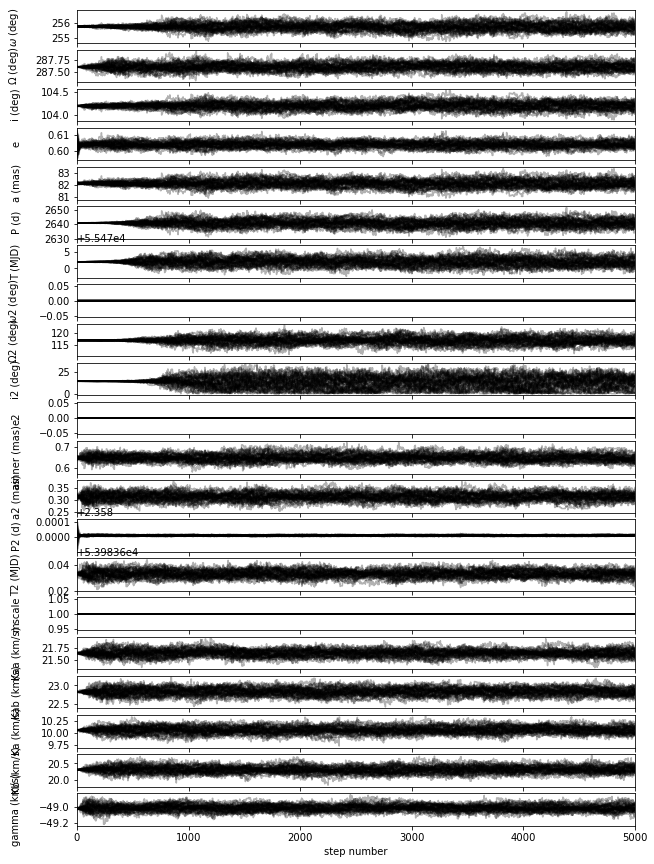

In [70]:
## look at walkers 
target_hd = '173093'

fig, axes = plt.subplots(21, figsize=(10, 15), sharex=True)
samples = sampler.get_chain()
labels=["$\omega$ (deg)","$\Omega$ (deg)","i (deg)","e","a (mas)","P (d)","T (MJD)",
       "$\omega$2 (deg)","$\Omega$2 (deg)","i2 (deg)","e2","ainner (mas)","a2 (mas)","P2 (d)","T2 (MJD)","mscale",
       "Kaa (km/s)","Kab (km/s)","Ka (km/s)","Kb (km/s)","gamma (km/s)"]
for i in range(nDim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

directory='/Users/tgardne/ARMADA_orbits/HD%s/'%target_hd
if not os.path.exists(directory):
    os.makedirs(directory)
plt.savefig('/Users/tgardne/ARMADA_orbits/HD%s/HD%s_chains.pdf'%(target_hd,target_hd))

plt.show()

In [71]:
try:
    tau = sampler.get_autocorr_time()
    print('tau = ')
    print(tau)
    print(10*'-')

    burn = int(3*np.mean(tau))
    print('burn = ')
    print(burn)
    print(10*'-')

    thin = int(np.mean(tau)/2)
    print('thin = ')
    print(thin)
    print(10*'-')
except:
    print('did not run long enough!!!')
    burn = 100
    thin = 10

/usr/local/anaconda/lib/python3.8/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


did not run long enough!!!


In [72]:
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
print(flat_samples.shape)

(20580, 21)


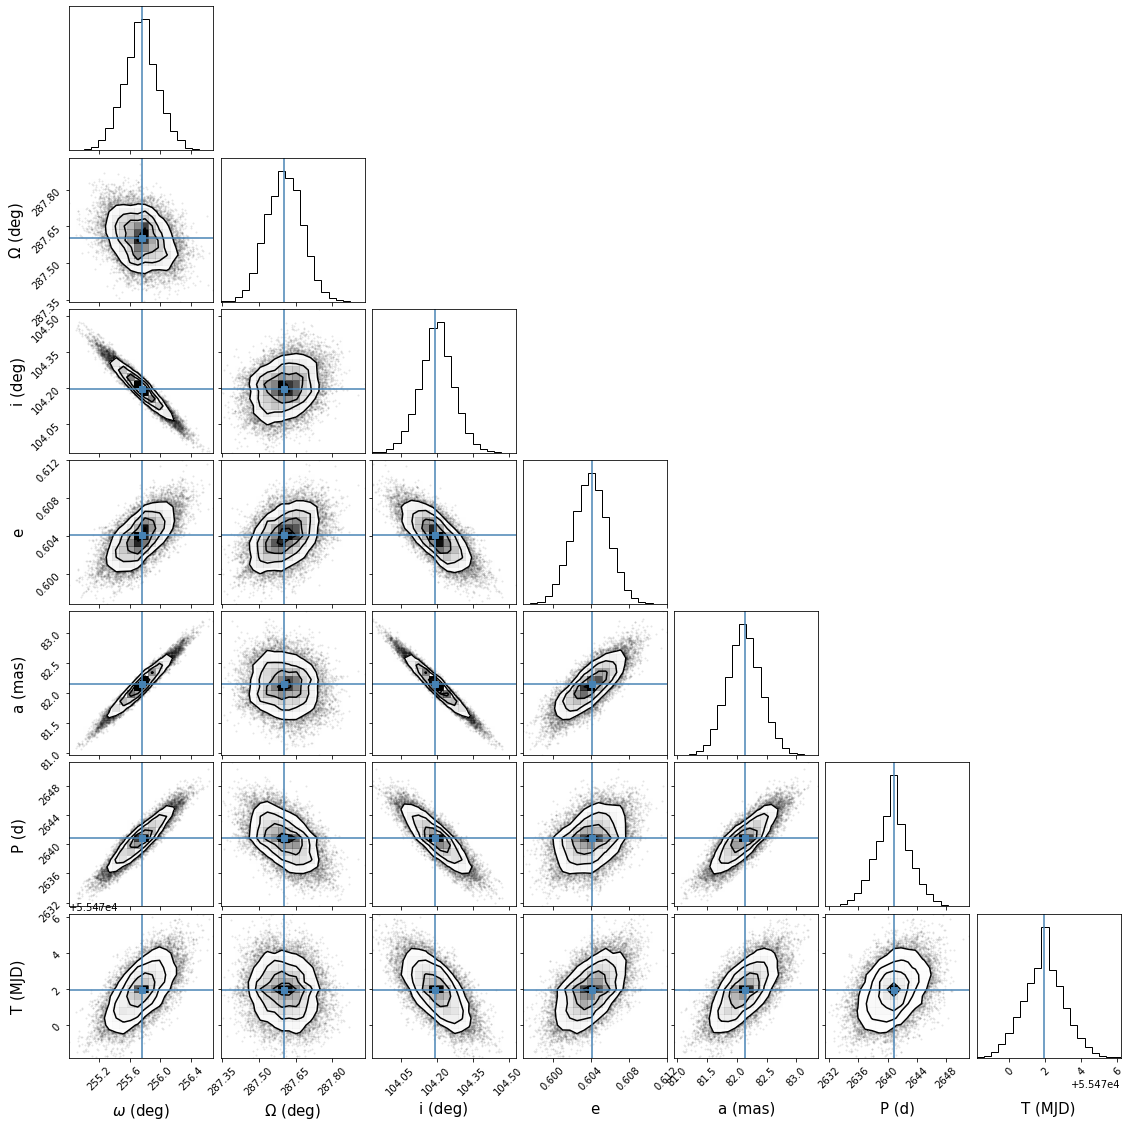

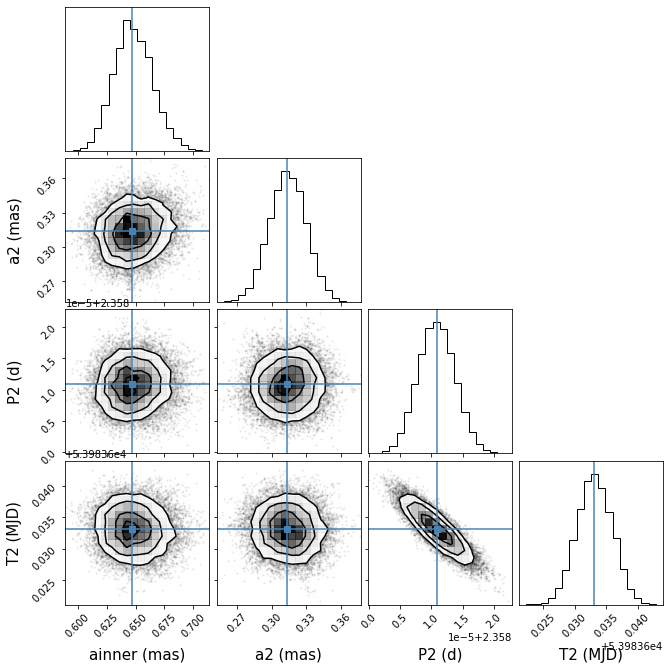

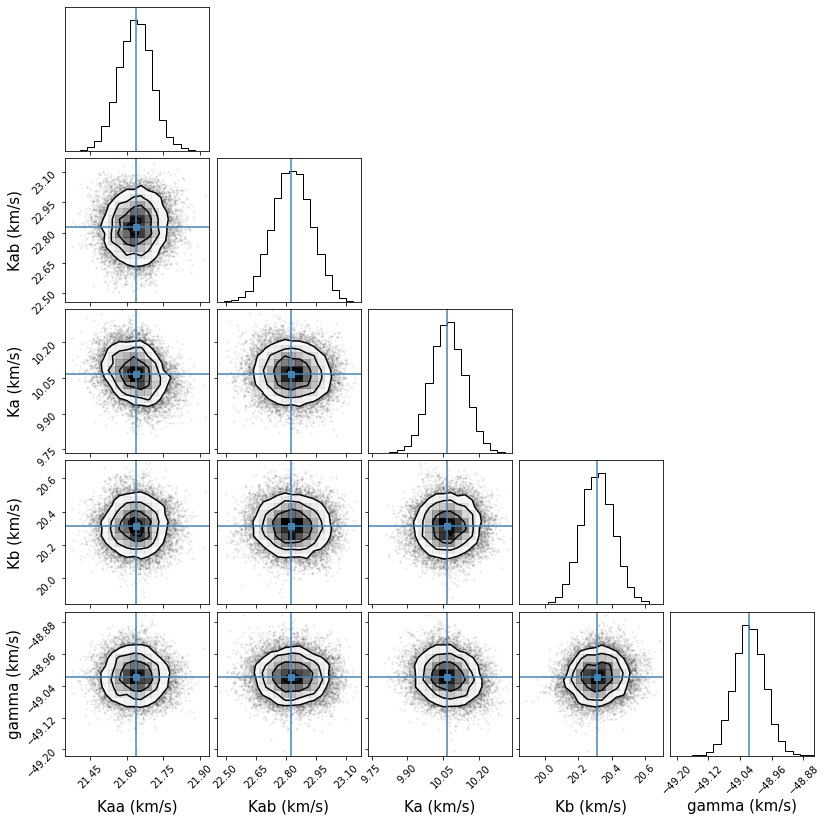

In [73]:
#samples = sampler.chain[:,burn:, :].reshape((-1, nDim));
#print("Number of posterior samples:", len(flat_samples))

fig = corner.corner(flat_samples[:,:7], labels=labels[:7],truths=initial_params[:7],label_kwargs={"fontsize":15})
plt.savefig('/Users/tgardne/ARMADA_orbits/HD%s/HD%s_corner_outer.pdf'%(target_hd,target_hd))
plt.show()

fig = corner.corner(flat_samples[:,11:15], labels=labels[11:15],truths=initial_params[11:15],label_kwargs={"fontsize":15})
plt.savefig('/Users/tgardne/ARMADA_orbits/HD%s/HD%s_corner_inner.pdf'%(target_hd,target_hd))
plt.show()

fig = corner.corner(flat_samples[:,16:], labels=labels[16:],truths=initial_params[16:],label_kwargs={"fontsize":15})
plt.savefig('/Users/tgardne/ARMADA_orbits/HD%s/HD%s_corner_rv.pdf'%(target_hd,target_hd))
plt.show()

In [79]:
## Mass / Orbit Information

a_inner_mcmc = flat_samples[:,11]

a_mcmc = flat_samples[:,4]
P_mcmc = flat_samples[:,5]
T_mcmc = flat_samples[:,6]
e_mcmc = flat_samples[:,3]
w_mcmc = flat_samples[:,0]
bigw_mcmc = flat_samples[:,1]
inc_mcmc = flat_samples[:,2]

a2_mcmc = flat_samples[:,12]
P2_mcmc = flat_samples[:,13]
T2_mcmc = flat_samples[:,14]
e2_mcmc = flat_samples[:,10]
w2_mcmc = flat_samples[:,7]
bigw2_mcmc = flat_samples[:,8]
inc2_mcmc = flat_samples[:,2]

K_aa_mcmc = flat_samples[:,16]
K_ab_mcmc = flat_samples[:,17]
K_a_mcmc = flat_samples[:,18]
K_b_mcmc = flat_samples[:,19]
gamma_mcmc = flat_samples[:,20]

## distance from HIP/GAIA
plx_hip = ufloat(0.013781,0.000718)
#plx_gaia = ufloat(0.01496,0.00053)

## Radial Velocity parameters included
semi1 = P2_mcmc*24*60*60*K_aa_mcmc*(1-e2_mcmc**2)**(1/2)/(2*np.pi)/1.496e8/np.sin(inc2_mcmc*np.pi/180)
#print(semi1)

#mratio_err = K_ab_err / K_aa_err
#d_rv = semi1 / ((a2_err/(1+mratio_err)*mratio)/1000) ## WHICH SEMI IS IT?!?!?
#d_rv = semi1 / (a2_err/1000)
#d_rv = semi1 / ((a2_err - a1_err)/1000)

semi_out1 = P_mcmc*24*60*60*K_a_mcmc*(1-e_mcmc**2)**(1/2)/(2*np.pi)/1.496e8/np.sin(inc_mcmc*np.pi/180)
semi_out2 = P_mcmc*24*60*60*K_b_mcmc*(1-e_mcmc**2)**(1/2)/(2*np.pi)/1.496e8/np.sin(inc_mcmc*np.pi/180)
d_rv = (semi_out1+semi_out2) / (a_mcmc/1000)

print('Distance from HIP = ')
print(1/plx_hip)
#print('Distance from GAIA = %s pc'%(1/plx_gaia))
print('Distance from RV = ')
print(np.mean(d_rv),np.std(d_rv))

#d_err = 1/plx_hip
d_err = d_rv

print('Mratio from Kamps: ', np.mean(K_ab_mcmc/K_aa_mcmc),np.std(K_ab_mcmc/K_aa_mcmc))
print('Mratio outer from Kamps: ', np.mean(K_b_mcmc/K_a_mcmc),np.std(K_b_mcmc/K_a_mcmc))
print('Mratio from semis: ', np.mean((a_inner_mcmc - a2_mcmc) / a2_mcmc), np.std((a_inner_mcmc - a2_mcmc) / a2_mcmc))

mratio_inner = K_ab_mcmc/K_aa_mcmc
mratio_outer = K_b_mcmc/K_a_mcmc

Distance from HIP = 
73+/-4
Distance from RV = 
73.8350438435375 0.41809664284994447
Mratio from Kamps:  1.0552362297544355 0.005422870537500088
Mratio outer from Kamps:  2.01757399594175 0.016860215019979672
Mratio from semis:  1.071128250630812 0.1134372013110031


In [84]:
print('-'*10)
print('Masses from distance')
print('-'*10)

sum1 = (a_mcmc*d_rv/1000)**3 / (P_mcmc/365.25)**2
print('M1+M2+M3 = ', np.mean(sum1),np.std(sum1))

print('-'*10)
minner_tot = (a_inner_mcmc*d_rv/1000)**3 / (P2_mcmc/365.25)**2
print('M1+M2=',np.mean(minner_tot),np.std(minner_tot))

print('-'*10)
m1 = minner_tot / (1+1/mratio_inner)
m2 = minner_tot - m1
m3 = sum1 - m1 - m2
print('M1=', np.mean(m1),np.std(m1))
print('M2=', np.mean(m2),np.std(m2))
print('M3=', np.mean(m3),np.std(m3))

----------
Masses from distance
----------
M1+M2+M3 =  4.264988602324401 0.05277175942052646
----------
M1+M2= 2.635337496686934 0.20788635224875116
----------
M1= 1.3530813777419177 0.10689400721327193
M2= 1.282256118945017 0.10110378656545983
M3= 1.6296511056374665 0.20671443831903016
